# 컬러 영상 영역분할

공개SW협회의 주관의 Open Up의 인공지능“이미지의 사물 검출에 딥러닝 활용(심화)”전문교육 프로그램중의 교재를 가져와서 수정함

https://edu.kosslab.kr/course/view.php?id=34


In [4]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import os
import random
import cv2

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
# from tensorflow.keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

# 데이터 준비

## 데이터 다운로드

http://www.robots.ox.ac.uk/~vgg/data/pets/ 의 데이터를 사용.

In [5]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2021-08-12 06:06:45--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2021-08-12 06:06:45--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  21.1MB/s    in 37s     

2021-08-12 06:07:23 (20.5 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2021-08-12 06:07:23--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Co

## 압축 풀기

In [ ]:
!tar -xvzf images.tar.gz
!tar -xvzf annotations.tar.gz

## 불필요한 파일 삭제

In [9]:
!rm images/*.mat
!rm annotations/trimaps/._*

## 풀린 데이터 파일 구조

```
images/
  Abyssinian_1.jpg
  Abyssinian_10.jpg
  Abyssinian_100.jpg
  ...
annotations/
  trimaps/
    Abyssinian_1.png
    Abyssinian_10.png
    Abyssinian_100.png
    ...
  xmls/            # 사용한함.  PASCAL VOC Format의 object dtection 레이블
    Abyssinian_1.xml
    Abyssinian_10.xml
    Abyssinian_100.xml
    ...
  README           # 사용 안한
  list.txt         # 사용 안함
  test.txt         # 사용 안함
  trainval.txt     # 사용 안함
```

In [16]:
!ls -al images/*jpg | wc
!ls -al annotations/trimaps/*png | wc

   7390   66510  525734
   7390   66510  607024


## 파일 보기

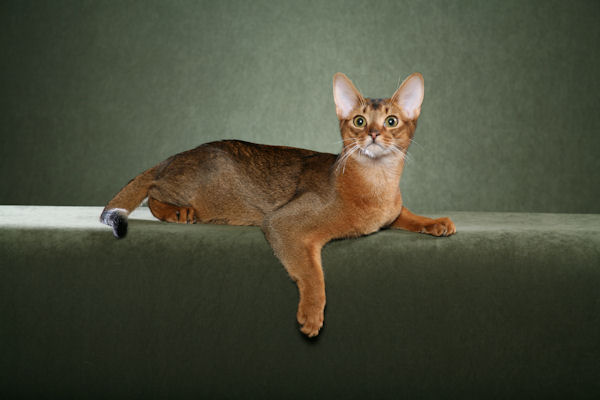

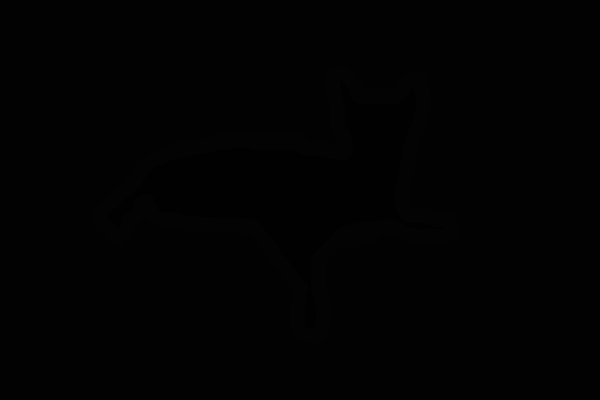

In [17]:
from IPython.display import Image, display

display(Image('images/Abyssinian_1.jpg'))
display(Image('annotations/trimaps/Abyssinian_1.png'))


annoation 파일은 일반 이미지 파일이 아니고, 각 픽셀별 category 값이 담긴 파일이다.
그냥 봐서는 보이지 않는다.

(400, 600)


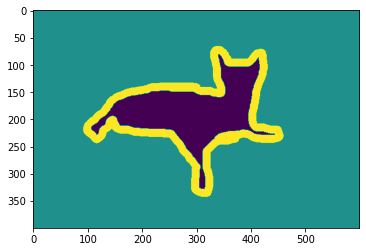

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3]


In [18]:
label = cv2.imread('annotations/trimaps/Abyssinian_1.png', cv2.IMREAD_GRAYSCALE)
print(label.shape)
plt.imshow(label)
plt.show()
print(label[100][300:360])

category 값은 README 파일에 명시되어 있다.
- 1: 전경
- 2: 배경
- 3: 테두리

# ImageDataGenerator 선언

keras의 ImageDataGenerator를 사용하여 파일을 읽는다.

파일의 크기가 제각각이라 256x256 사이즈로 로딩한다.


In [23]:
from keras.preprocessing.image import ImageDataGenerator

def image_preprocessor(image):
  # normalizing
  return image/255.0

def label_preprocessor(label):
  # 전경/배경/이외의 구분을 전경/배경으로 바꾼다.
  label[ label==1 ] = 1  # 전경(1)은 1로
  label[ label==2 ] = 0  # 배경(2)은 0으로
  label[ label==3 ] = 1  # 이외(3)도 1로. 전경의 테두리 같다. 전경으로 치자.
  return label


img_generator = ImageDataGenerator(
    preprocessing_function=image_preprocessor,
    validation_split=0.2)


train_img_generator = img_generator.flow_from_directory(".", 
    classes=["images"],
    target_size=(256, 256), 
    batch_size=64,
    interpolation="nearest",
    class_mode=None,
    shuffle=True,
    subset='training',
    seed=42)

validation_img_generator = img_generator.flow_from_directory(".",
    classes=["images"],
    target_size=(256, 256), 
    batch_size=64,
    interpolation="nearest",
    class_mode=None,
    shuffle=True,
    subset='validation',
    seed=42)



label_generator = ImageDataGenerator(
    preprocessing_function=label_preprocessor,
    validation_split=0.2)


train_label_generator = label_generator.flow_from_directory(
    "annotations", 
    classes=["trimaps"], 
    target_size=(256, 256), 
    batch_size=64,
    interpolation="nearest",
    color_mode="grayscale",    
    class_mode=None,
    shuffle=True,
    subset='training',
    seed=42)


validation_label_generator = label_generator.flow_from_directory(
    "annotations", 
    classes=["trimaps"], 
    target_size=(256, 256), 
    batch_size=64,
    interpolation="nearest",
    color_mode="grayscale",    
    class_mode=None,
    shuffle=True,
    subset='validation',  
    seed=42)

train_data_generator = zip(train_img_generator, train_label_generator)
validation_data_generator = zip(validation_img_generator, validation_label_generator)



Found 5912 images belonging to 1 classes.
Found 1478 images belonging to 1 classes.
Found 5912 images belonging to 1 classes.
Found 1478 images belonging to 1 classes.


## 데이터 살펴보기

In [24]:
batch_x, batch_y = next(train_data_generator)

print(batch_x.shape)
print(batch_y.shape)

(64, 256, 256, 3)
(64, 256, 256, 1)


In [25]:
print(batch_x[0])
print(batch_y[0])

[[[0.77254903 0.68235296 0.61960787]
  [0.7921569  0.7019608  0.6392157 ]
  [0.77254903 0.6901961  0.6156863 ]
  ...
  [0.49411765 0.30980393 0.14509805]
  [0.52156866 0.31764707 0.16470589]
  [0.5294118  0.3254902  0.17254902]]

 [[0.78039217 0.69803923 0.6313726 ]
  [0.78039217 0.69803923 0.6313726 ]
  [0.7882353  0.7137255  0.64705884]
  ...
  [0.56078434 0.35686275 0.2       ]
  [0.5529412  0.34509805 0.17254902]
  [0.54509807 0.3372549  0.16470589]]

 [[0.7882353  0.7058824  0.6392157 ]
  [0.78039217 0.7058824  0.6392157 ]
  [0.7921569  0.7176471  0.65882355]
  ...
  [0.5568628  0.34901962 0.19215687]
  [0.54901963 0.34117648 0.16862746]
  [0.5647059  0.35686275 0.18431373]]

 ...

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         0.99215686]
  [0.99607843 1.         0.9764706 ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]


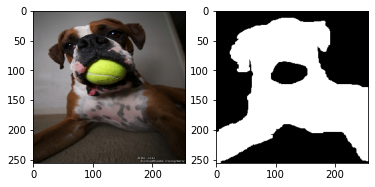

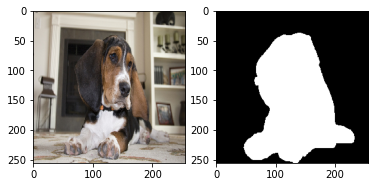

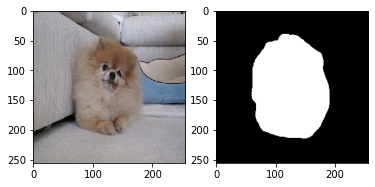

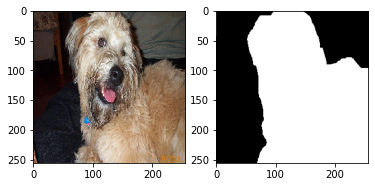

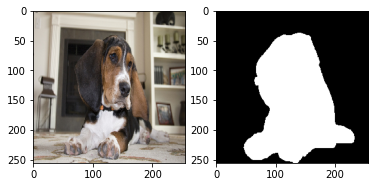

In [26]:
import matplotlib.pyplot as plt

def plotTrainData(x, y):
    for i in range(5):
        ix = np.random.randint(0, len(x))
        plt.subplot(1,2,1)
        plt.imshow(x[ix])
        
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(y[ix]), 'gray') # np.squeeze()는 (256,26,1)을 (256,256)으로 변환
        plt.show()
   
plotTrainData(batch_x, batch_y)

# U-Net 모델 정의

In [27]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  # down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  # bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  # upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  # classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  # model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  
  return model

# 모델 컴파일과 학습

In [28]:
model = unet()

model.compile(optimizer = 'rmsprop', loss='binary_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 8)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [30]:
hist = model.fit(
    train_data_generator,
    steps_per_epoch=train_img_generator.samples/64,
    validation_data=validation_data_generator,
    validation_steps=validation_img_generator.samples/64,
    epochs=10, 
    verbose=1)

Epoch 1/10
92/92 [==============================] - 48s 527ms/step - loss: 0.4715 - val_loss: 0.4919
Epoch 2/10
92/92 [==============================] - 48s 526ms/step - loss: 0.4568 - val_loss: 0.4619
Epoch 3/10
92/92 [==============================] - 48s 521ms/step - loss: 0.4346 - val_loss: 0.4668
Epoch 4/10
92/92 [==============================] - 47s 517ms/step - loss: 0.4083 - val_loss: 0.4229
Epoch 5/10
92/92 [==============================] - 47s 517ms/step - loss: 0.3745 - val_loss: 0.4189
Epoch 6/10
92/92 [==============================] - 48s 522ms/step - loss: 0.3498 - val_loss: 0.3473
Epoch 7/10
92/92 [==============================] - 48s 525ms/step - loss: 0.3302 - val_loss: 0.3644
Epoch 8/10
92/92 [==============================] - 48s 528ms/step - loss: 0.3082 - val_loss: 0.4152
Epoch 9/10
92/92 [==============================] - 47s 517ms/step - loss: 0.2863 - val_loss: 0.3490
Epoch 10/10
92/92 [==============================] - 47s 516ms/step - loss: 0.2742 - val_lo

## 로스 보기

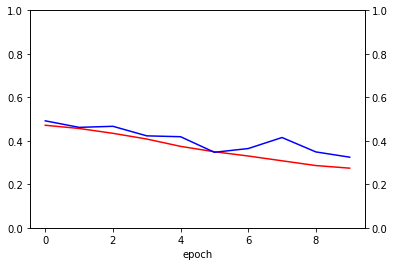

In [31]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'r')
loss_ax.plot(hist.history['val_loss'], 'b')
loss_ax.set_ylim([0.0, 1.0])


loss_ax.set_xlabel('epoch')

plt.show()

## 테스트 결과 보기

In [32]:
import matplotlib.pyplot as plt

def plotPredictions(model, x, y):

  predicted = model.predict(x)
  predicted = (predicted > 0.5).astype(np.uint8)

  for i in range(5):

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("image")
    plt.axis('off')
    plt.imshow(x[i])
    plt.subplot(1,3,2)
    plt.title("label")
    plt.axis('off')
    plt.imshow(y[i].squeeze(), 'gray')
    plt.subplot(1,3,3)
    plt.title("predicted")    
    plt.axis('off')
    plt.imshow(predicted[i].squeeze(), 'gray')
    plt.show()

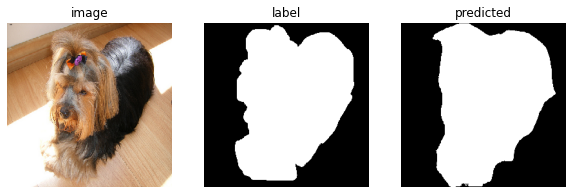

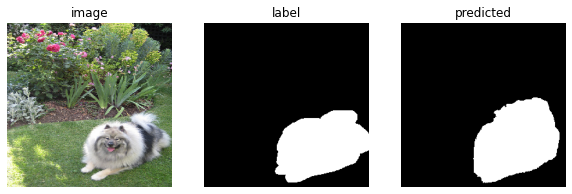

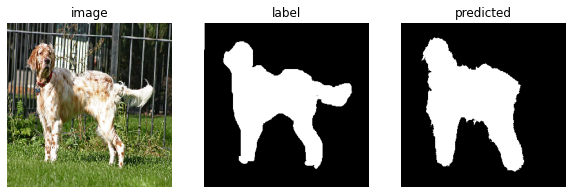

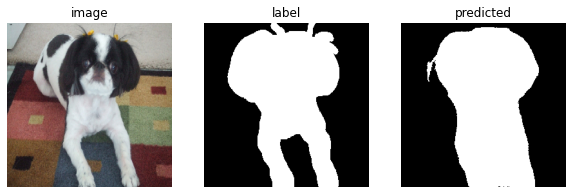

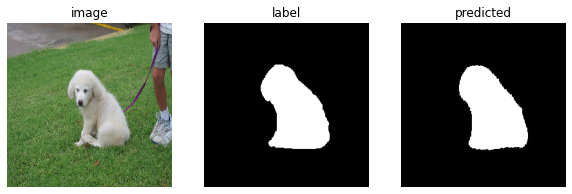

In [33]:
plotPredictions(model, batch_x, batch_y)